In [2]:
# ============================================================
# 03_regularization_paths_and_quantile_regression.ipynb
# Medical Cost Prediction — Coefficient Paths & Quantile Regression
# ============================================================

# --- 1) Imports & Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", rc={"figure.figsize": (7,4)})

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, lasso_path, QuantileRegressor, ElasticNet
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# --- 2) Load Data ---
df = pd.read_csv("../data/insurance.csv")
print(df.shape, df.isna().sum().sum(), "missing values total")


(1338, 7) 0 missing values total


In [4]:
# --- 3) Feature Engineering (domain-driven) ---
df_fe = df.copy()
df_fe["smoker_int"] = (df_fe["smoker"] == "yes").astype(int)
df_fe["smoker_age"] = df_fe["smoker_int"] * df_fe["age"]
df_fe["smoker_bmi"] = df_fe["smoker_int"] * df_fe["bmi"]
df_fe["age_bmi"]    = df_fe["age"] * df_fe["bmi"]

target = "charges"
base_num = ["age","bmi","children"]
eng_num  = ["smoker_age","smoker_bmi","age_bmi"]
num_cols = base_num + eng_num
cat_cols = ["sex","smoker","region"]

X = df_fe.drop(columns=[target, "smoker_int"])
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [5]:
# --- 4) Preprocessor (Scaler + OneHot) ---
num_transformer = Pipeline([("scaler", StandardScaler())])
cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)


X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# One-Hot
try:
    feat_names = preprocessor.get_feature_names_out()
except:
    # fallback
    cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
    feat_names = np.concatenate([np.array(num_cols), cat_names])



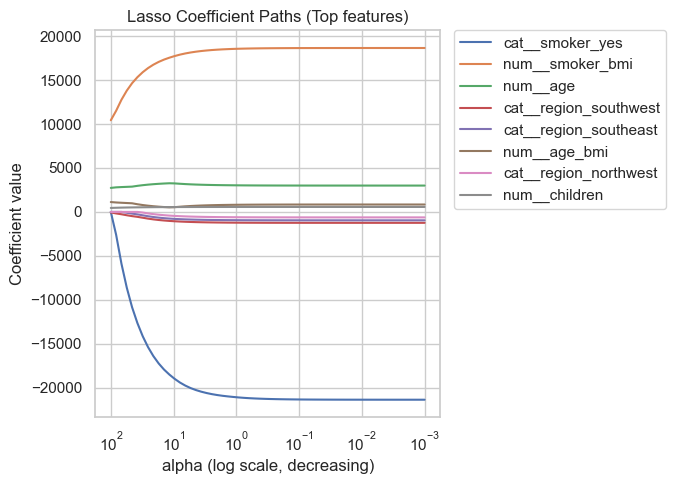

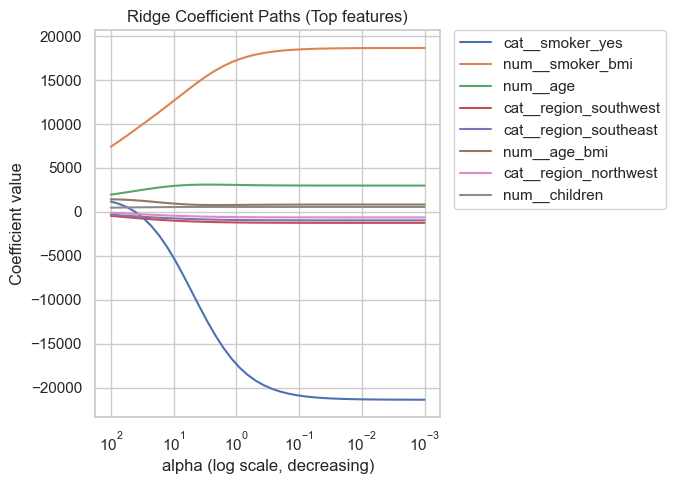

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 5) Helper Metrics ---
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9)))

def summary_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    print(f"[{name}] RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f} | MAPE: {mp:.2f}%")
    return rmse, mae, r2, mp

# ---------- Prepare data and feature names ----------
Xtt = np.asarray(X_train_trans)        # matrix after preprocessing
yt  = np.asarray(y_train).ravel()

# Center X and y (acts like fit_intercept=True for paths)
Xc = Xtt - Xtt.mean(axis=0, keepdims=True)
yc = yt  - yt.mean()

# Feature names (try to get from your preprocessor; otherwise fallback)
try:
    feat_names
except NameError:
    feat_names = None

if feat_names is None:
    prep = None
    for obj in ("best_en_log", "preprocessor"):
        try:
            if obj == "best_en_log":
                prep = best_en_log.named_steps["prep"]
            else:
                prep = preprocessor
            feat_names = prep.get_feature_names_out()
            break
        except Exception:
            pass

if feat_names is None:
    feat_names = [f"f{i}" for i in range(Xtt.shape[1])]

# ============================================================
# A) Regularization Paths (Lasso & Ridge)
# ============================================================

# --- A1) Lasso coefficient path ---
alphas_lasso = np.logspace(2, -3, 60)

# Correct return order: alphas, coefs, dual_gaps
alphas_lasso_out, coefs_lasso, _ = lasso_path(Xc, yc, alphas=alphas_lasso)
# coefs_lasso.shape == (n_features, n_alphas)

# Pick top features by |coef| at the middle alpha
mid_idx    = coefs_lasso.shape[1] // 2
abs_at_mid = np.abs(coefs_lasso[:, mid_idx])
top_k      = min(8, coefs_lasso.shape[0])
top_idx    = np.argsort(-abs_at_mid)[:top_k]
top_feat_names = [feat_names[i] for i in top_idx]

# Plot Lasso paths
plt.figure(figsize=(7, 5))
for i in top_idx:
    plt.plot(alphas_lasso_out, coefs_lasso[i, :], label=feat_names[i])
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("alpha (log scale, decreasing)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Paths (Top features)")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# --- A2) Ridge coefficient path ---
alphas_ridge = np.logspace(2, -3, 40)

ridge_coefs = []
for a in alphas_ridge:
    rd = Ridge(alpha=a, fit_intercept=False, random_state=RANDOM_STATE)  # centered data
    rd.fit(Xc, yc)
    ridge_coefs.append(rd.coef_)
ridge_coefs = np.array(ridge_coefs).T  # (n_features, n_alphas)

# Plot Ridge paths
plt.figure(figsize=(7, 5))
for i in top_idx:
    plt.plot(alphas_ridge, ridge_coefs[i, :], label=feat_names[i])
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("alpha (log scale, decreasing)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (Top features)")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# --- Coefficient stability table ---

stability = (
    pd.DataFrame({
        "feature": [feat_names[i] for i in top_idx],
        "coef_range_lasso": np.ptp(coefs_lasso[top_idx, :], axis=1),
        "coef_range_ridge": np.ptp(ridge_coefs[top_idx, :], axis=1),
    })
    .sort_values("coef_range_lasso")
)




=== Quantile Regression (Median as point prediction) ===
[QR-Median (q=0.5)] RMSE: 4709.22 | MAE: 2114.71 | R²: 0.857 | MAPE: 14.71%
Pinball loss (q=0.5): 1057.35
PI(80%) coverage: 81.34% | avg width: 6208.31


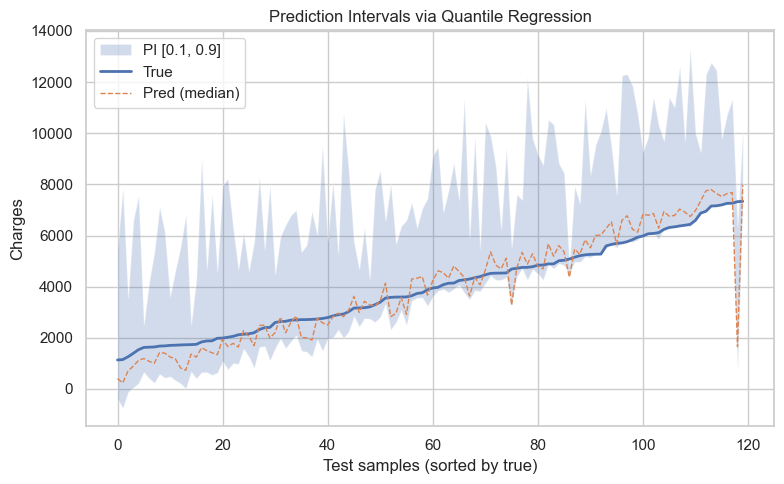


Coverage table (empirical vs theoretical):


,interval,theoretical,empirical
0,"[0.05,0.95]",89%,89.2%
1,"[0.10,0.90]",80%,81.3%
2,"[0.20,0.80]",60%,61.9%
3,"[0.25,0.75]",50%,51.1%



=== Comparison vs ElasticNet (point prediction) ===
[ElasticNet (point)] RMSE: 4896.79 | MAE: 3326.47 | R²: 0.846 | MAPE: 37.79%
[QR-Median (point)] RMSE: 4709.22 | MAE: 2114.71 | R²: 0.857 | MAPE: 14.71%


(np.float64(4709.224872944864),
 2114.7050470011395,
 0.8571531072050164,
 np.float64(14.7134225855759))

In [ ]:
# ============================================================
# B) Quantile Regression (Prediction Intervals)
# ============================================================

# --- B1) Train Quantile models for q in {0.1, 0.5, 0.9} ---

def fit_qr(q, alpha=1e-4):
    pipe = Pipeline([
        ("prep", preprocessor),
        ("qr", QuantileRegressor(quantile=q, alpha=alpha, fit_intercept=True))
    ])
    pipe.fit(X_train, y_train)
    return pipe

q_lower, q_med, q_upper = 0.1, 0.5, 0.9
qr_low   = fit_qr(q_lower, alpha=1e-4)
qr_med   = fit_qr(q_med,   alpha=1e-4)
qr_high  = fit_qr(q_upper, alpha=1e-4)

y_pred_low  = qr_low.predict(X_test)
y_pred_med  = qr_med.predict(X_test)   # مثل median regressor؛ MAE-optimal
y_pred_high = qr_high.predict(X_test)

# --- B2) Metrics (Median model as point-estimate) ---
print("\n=== Quantile Regression (Median as point prediction) ===")
summary_metrics("QR-Median (q=0.5)", y_test, y_pred_med)
print(f"Pinball loss (q=0.5): {mean_pinball_loss(y_test, y_pred_med, alpha=0.5):.2f}")

# --- B3) Prediction Interval (q=0.1 to q=0.9) ---
pi_low, pi_high = y_pred_low, y_pred_high
coverage = np.mean((y_test >= pi_low) & (y_test <= pi_high))
avg_width = np.mean(pi_high - pi_low)
print(f"PI(80%) coverage: {coverage*100:.2f}% | avg width: {avg_width:.2f}")

# --- B4) Visualize Intervals (sample to avoid clutter) ---

n_show = min(120, len(y_test))
order  = np.argsort(y_test.values)[:n_show]  
yt = y_test.values[order]
yl = pi_low[order]
ym = y_pred_med[order]
yu = pi_high[order]

plt.figure(figsize=(8,5))
x = np.arange(n_show)
plt.fill_between(x, yl, yu, alpha=0.25, label=f"PI [{q_lower:.1f}, {q_upper:.1f}]")
plt.plot(x, yt, linewidth=2, label="True")
plt.plot(x, ym, linewidth=1, linestyle="--", label="Pred (median)")
plt.xlabel("Test samples (sorted by true)")
plt.ylabel("Charges")
plt.title("Prediction Intervals via Quantile Regression")
plt.legend()
plt.tight_layout()
plt.show()

# --- B5) Coverage calibration across multiple intervals (optional check) ---
def coverage_for(q_lo, q_hi):
    lo = fit_qr(q_lo).predict(X_test)
    hi = fit_qr(q_hi).predict(X_test)
    return np.mean((y_test >= lo) & (y_test <= hi))

grid = [(0.05,0.95), (0.1,0.9), (0.2,0.8), (0.25,0.75)]
cov_table = []
for qlo, qhi in grid:
    cov = coverage_for(qlo, qhi)
    cov_table.append({"interval": f"[{qlo:.2f},{qhi:.2f}]", "theoretical": f"{int((qhi-qlo)*100)}%", "empirical": f"{cov*100:.1f}%"})
print("\nCoverage table (empirical vs theoretical):")
display(pd.DataFrame(cov_table))

# --- B6) Compare to (regularized) ElasticNet as baseline point model ---
en_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=20000, random_state=RANDOM_STATE))
]).fit(X_train, y_train)

y_pred_en = en_pipe.predict(X_test)
print("\n=== Comparison vs ElasticNet (point prediction) ===")
summary_metrics("ElasticNet (point)", y_test, y_pred_en)
summary_metrics("QR-Median (point)", y_test, y_pred_med)

In [20]:

# --- C) Quick Coefficient peek for QR median (interpretability) ---
qr_med_prep = Pipeline([
    ("prep", preprocessor)
]).fit(X_train, y_train)

Xtr = qr_med_prep.transform(X_train)
qr_med_est = QuantileRegressor(quantile=0.5, alpha=1e-4, fit_intercept=True)
qr_med_est.fit(Xtr, y_train)

try:
    feat_names_qr = qr_med_prep.get_feature_names_out()
except:
    cat_names = qr_med_prep.named_transformers_["cat"].get_feature_names_out(cat_cols)
    feat_names_qr = np.concatenate([np.array(num_cols), cat_names])

coef_qr = pd.DataFrame({
    "feature": list(feat_names_qr),
    "coef": qr_med_est.coef_
}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
print("\nTop QR-median coefficients (by |coef|):")
display(coef_qr.head(12))


Top QR-median coefficients (by |coef|):


,feature,coef
7,cat__smoker_yes,-21621.191934
4,num__smoker_bmi,19563.880165
0,num__age,3232.673619
9,cat__region_southeast,-713.809631
10,cat__region_southwest,-673.759661
5,num__age_bmi,600.123696
6,cat__sex_male,-517.968294
2,num__children,492.773533
8,cat__region_northwest,-371.008151
1,num__bmi,-217.236416


In [21]:
# --- D) Small Summary ---
print("\n=== Notebook Summary ===")
print(f"- Drawn Lasso/Ridge coefficient paths over alpha (top {top_k} features).")
print(f"- Trained Quantile Regression at q={q_lower}, {q_med}, {q_upper} for PI.")
print(f"- Empirical 80% coverage: {coverage*100:.1f}% (target=80%).")
print("- Compared QR-median vs ElasticNet (point).")


=== Notebook Summary ===
- Drawn Lasso/Ridge coefficient paths over alpha (top 8 features).
- Trained Quantile Regression at q=0.1, 0.5, 0.9 for PI.
- Empirical 80% coverage: 81.3% (target=80%).
- Compared QR-median vs ElasticNet (point).
